# Dataset

In [31]:
from sklearn.preprocessing import LabelEncoder
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import torchaudio

In [32]:
class CustomAudioDataset(Dataset):
    def __init__(self, df, recording_dir, transform=None, target_transform=None, sample_rate=32000, number_of_samples = 32000*3, device = "cpu"):
        df['filepath'] = df.apply(lambda x: f"{recording_dir}{x['Latin name']}/{str(x['id'])}.mp3" , axis=1)
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['Latin name'])
        
        self.sample_rate = sample_rate
        self.filepath = df['filepath'].to_numpy()
        self.label = df['label'].to_numpy()
        self.device = device
        self.recording_dir = recording_dir
        if transform:
            self.transform = transform.to(self.device)
        self.target_transform = target_transform
        self.le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        self.number_of_samples = number_of_samples 

    def __len__(self):
        return self.filepath.size

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.filepath[idx])
        waveform = waveform.to(self.device)
        label = self.label[idx]
        audio= self.resample_if_necessary(waveform, sr)
        audio = self.mix_down_if_necessary(audio)
        # audio = torchaudio.functional.gain(audio, gain_db=10)
        # audio = torchaudio.functional.phaser(audio, sample_rate=self.sample_rate)
        audio = self.cut_if_necessary(audio)
        audio = self.right_pad_if_necessary(audio)

        audio = self.transform(audio)
        return audio, label
    
    def mix_down_if_necessary(self, audio):
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim = 0,  keepdim=True)
        return audio
    
    def resample_if_necessary(self, audio, sr):
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            audio = resampler(audio)
        return audio
    
    def get_sample_rate(self):
        return self.sample_rate
    
    def get_mapping(self):
        return self.le_name_mapping

    def cut_if_necessary(self, audio):
        if audio.shape[1] > self.number_of_samples:
            audio  = audio[:, :self.number_of_samples]
        return audio
            

    def right_pad_if_necessary(self, audio):
        length_audio = audio.shape[1]
        if length_audio < self.number_of_samples:
            num_missing_samples = self.number_of_samples - length_audio
            last_dim_padding = (0, num_missing_samples)
            audio = torch.nn.functional.pad(audio, last_dim_padding)
        return audio
             


In [33]:
if torch.cuda.is_available():
    device_str = "cuda"
else:
    device_str = "cpu"

SEED = 123
RECORDINGS_DIR = '/media/jacek/E753-A120/recordings_30/'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1


mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

df = filter_recordings_30()

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = CustomAudioDataset(train_df, recording_dir=RECORDINGS_DIR, transform=mel_spectrogram, sample_rate=SAMPLE_RATE, number_of_samples = NUM_SAMPLES, device = device_str)
val_ds = CustomAudioDataset(val_df, recording_dir=RECORDINGS_DIR, device = device_str)
test_ds = CustomAudioDataset(test_df, recording_dir=RECORDINGS_DIR, device = device_str)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:43: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv("../data/xeno_canto_recordings.csv")


In [34]:
print(train_ds.__len__())
print(val_ds.__len__())
print(test_ds.__len__())

32968
4121
4121


In [35]:
import librosa
import matplotlib.pyplot as plt
def plot_spec(ax, spec, title):
    ax.set_title(title)
    ax.imshow(librosa.amplitude_to_db(spec), origin="lower", aspect="auto")

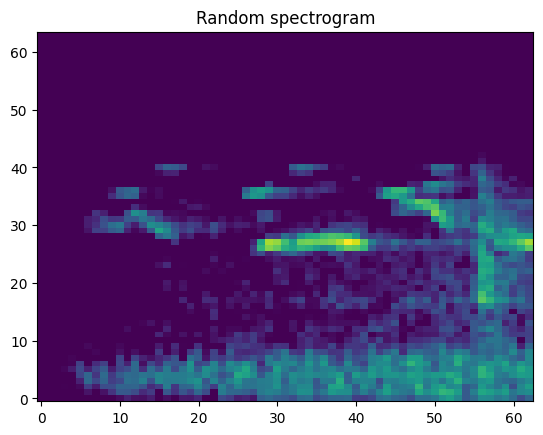

In [36]:
audio , label = train_ds[4]
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
plot_spec(axes, torch.abs(audio[0]), title="Random spectrogram")

In [37]:
# from birdclassification.visualization.plots import plot_waveform
# plot_waveform(audio.numpy()[0], 32000)
audio.shape

torch.Size([1, 64, 63])

# CNN network

In [38]:
from torch import nn
from torchsummary import summary

In [39]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / liniear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(
            3200, 30 #14976
        )
        self.softmax = nn.Softmax(dim = 1)
        
            
        
    def forward(self, input_data):
        print("input", input_data.shape)
        x = self.conv1(input_data)
        print("conv1", x.shape)
        x = self.conv2(x)
        print("conv2", x.shape)
        x = self.conv3(x)
        print("conv3", x.shape)
        x = self.conv4(x)
        print("conv4", x.shape)
        x = self.flatten(x)
        print("flatten", x.shape)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions 

In [40]:
cnn = CNNNetwork()
summary(cnn, (1, 128, 188)) 

input torch.Size([2, 1, 128, 188])
conv1 torch.Size([2, 16, 65, 95])
conv2 torch.Size([2, 32, 33, 48])
conv3 torch.Size([2, 64, 17, 25])
conv4 torch.Size([2, 128, 9, 13])
flatten torch.Size([2, 14976])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x14976 and 3200x30)

# Training

In [41]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
cnn = CNNNetwork().to(device)
device

'cpu'

In [42]:
def train_one_epoch(model, data_loader, loss_fn, optimiser, device):
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        #calculate loss
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
    
        #backpropagate loss and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    print(f"Loss {loss.item()}")
        
def train(model, data_loader, loss_fn, optimiser, device,epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_one_epoch(model, data_loader, loss_fn, optimiser, device)
    print("Finished training")

In [ ]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predctions = model(input)
        predicted_index = predctions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [43]:
BATCH_SIZE = 64
train_data_loader  = DataLoader(train_ds, batch_size= BATCH_SIZE)

In [44]:
EPOCHS = 1
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), LEARNING_RATE)
train(cnn, train_data_loader, loss_fn, optimiser, device, EPOCHS)

torch.save(cnn.state_dict(), "cnn.pth")

Epoch 1
input torch.Size([64, 1, 64, 63])
conv1 torch.Size([64, 16, 33, 32])
conv2 torch.Size([64, 32, 17, 17])
conv3 torch.Size([64, 64, 9, 9])
conv4 torch.Size([64, 128, 5, 5])
flatten torch.Size([64, 3200])
input torch.Size([64, 1, 64, 63])
conv1 torch.Size([64, 16, 33, 32])
conv2 torch.Size([64, 32, 17, 17])
conv3 torch.Size([64, 64, 9, 9])
conv4 torch.Size([64, 128, 5, 5])
flatten torch.Size([64, 3200])
input torch.Size([64, 1, 64, 63])
conv1 torch.Size([64, 16, 33, 32])
conv2 torch.Size([64, 32, 17, 17])
conv3 torch.Size([64, 64, 9, 9])
conv4 torch.Size([64, 128, 5, 5])
flatten torch.Size([64, 3200])
input torch.Size([64, 1, 64, 63])
conv1 torch.Size([64, 16, 33, 32])
conv2 torch.Size([64, 32, 17, 17])
conv3 torch.Size([64, 64, 9, 9])
conv4 torch.Size([64, 128, 5, 5])
flatten torch.Size([64, 3200])
input torch.Size([64, 1, 64, 63])
conv1 torch.Size([64, 16, 33, 32])
conv2 torch.Size([64, 32, 17, 17])
conv3 torch.Size([64, 64, 9, 9])
conv4 torch.Size([64, 128, 5, 5])
flatten torch


KeyboardInterrupt

